### Traveling Salesman Problem

### Algorithm: Genetic Algorithm 

In [942]:
# package list
import numpy as np
import sys
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import time

# Global Variables
# GA
POOL_SIZE = 20
TOURNAMENT_SIZE = 5# A.R. algorithm인 경우 3
MAX_ITERATION = 500000

# SA
MAX_EVALUATION = 100
SUB_ITERATIONS = 50
TEMPERATURE = 100
COOLING_RATIO = 0.5
TEMP_LIMIT = 1

np.random.seed(0)
# Plot Settings
PLOT_MODE = False # Draw Route
plt.ion()

# First City Index
FIRST_IDX = 0

In [943]:
file_path = '/Users/jiseoksong/Desktop/학부 수업/23-2/인공지능/4주차 과제/AI-W04-08-lab-source-data/data2.txt'

# Step 1. Data Loading

In [944]:
def fileloader():
    #     Data Format
    #     ---------------------------------------------------------
    #     NAME : pia3056
    #     COMMENT : Bonn VLSI data set with 3056 points
    #     COMMENT : Uni Bonn, Research Institute for Discrete Math
    #     COMMENT : Contributed by Andre Rohe
    #     TYPE : TSP
    #     DIMENSION : 3056 -----------------------------|
    #     EDGE_WEIGHT_TYPE : EUC_2D                     |
    #     NODE_COORD_SECTION                            |
    #     1 0 11 (2 dimentional coordinate of city)     |
    #     2 0 115                                       |
    #     ...                                           |
    #     ...(Total 3056 nodes)<------------------------|
    #     EOF
    #     ---------------------------------------------------------
    with open(file_path, "r") as file:
        file_str = file.readlines()

    # Get the coordinates of cities
    coord_str = file_str[8:-1]  # first city string to last city string (EOF 전까지)
    coord_list = np.zeros((len(coord_str), 2))
    for idx, item in enumerate(coord_str):
        items = item.split()
        coord_list[idx, 0], coord_list[idx, 1] = int(items[1]), int(items[2])

    return coord_list

# Step 2. Initialization

In [945]:
def initialize_greedy(coord_list, first_idx):
    cnt_cities = len(coord_list)
    # Initialize path and insert first city index to the first and last elements
    path = np.zeros(cnt_cities + 1, dtype=np.int32)
    path[0], path[-1] = first_idx, first_idx

    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    cities_tovisit = np.ones((cnt_cities), dtype=np.bool_)
    cities_tovisit[first_idx] = False

    # Iteratively Connect nearest cities
    for i in range(1, cnt_cities):
        start_idx = path[i - 1]
        distance_from_start = path_map[start_idx, :]
        nearest_list = np.argsort(distance_from_start)
        for idx in range(len(nearest_list)):
            # check the nearest city is visited
            if cities_tovisit[nearest_list[idx]]:
                nearest_city = nearest_list[idx]
                break
        cities_tovisit[nearest_city] = False
        path[i] = nearest_city

    return path_map, path


def initialize_random(coord_list, first_idx):
    cnt_cities = len(coord_list)
    path = np.zeros(cnt_cities + 1, dtype=np.int32)

    path[0], path[-1] = first_idx, first_idx
    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    # city indices without first city index
    cities_tovisit = np.delete(np.arange(cnt_cities), first_idx)
    cities_random = np.random.permutation(cities_tovisit)
    path[1:-1] = cities_random

    return path_map, path

def path_cost(path_map, path):
    # The array of cost between cities in the path
    cnt_cities = path_map.shape[0]
    cost_arr = np.zeros(cnt_cities)
    for i in range(cnt_cities):
        cost_arr[i] = path_map[path[i], path[i+1]]

    return cost_arr

# Step 3. Searching a path

## Algorithm 4. Genetic Algorithm 

In [946]:
def two_opt_swap(path_map, path, iterations, coord_list):
    cnt_cities = path_map.shape[0]
    # Save the best path

    cost_arr = path_cost(path_map, path)
    best_path = path.copy()
    best_cost = cost_arr.sum()
    
    for i in range(iterations):
        curr_path = best_path.copy()
        # Select two indices of flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))

        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
        cost_arr = path_cost(path_map, curr_path)

        # Compare to the best path
        curr_cost = cost_arr.sum()
        if curr_cost < best_cost:
            best_path = curr_path
            best_cost = curr_cost
    
    temperature = TEMPERATURE
    while temperature > TEMP_LIMIT:
        curr_path = best_path.copy()
        # Select two indices of flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))

        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
        cost_arr = path_cost(path_map, curr_path)
        curr_cost = cost_arr.sum()

        if curr_cost <= best_cost:
            best_path, best_cost = curr_path, curr_cost
        else:
            prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))
            if prob > np.random.rand(1):
                best_path, best_cost = curr_path, curr_cost
        temperature = temperature * COOLING_RATIO 
    return best_path, best_cost

def greedy_search(start, available_cities, coord_list):
    path=[]
    current_idx = start
    size=len(available_cities)
    
    while available_cities.size > 0:
        if len(available_cities) == 1:
            path.append(available_cities[0])
            break
        distances=euclidean_distances(coord_list[available_cities],
                                      coord_list[current_idx].reshape(1, 2)).flatten()
        
        next_idx=available_cities[np.argmin(distances)]
        path.append(next_idx)
        
        current_idx=next_idx
        available_cities=np.setdiff1d(available_cities, [next_idx], assume_unique=True)
        
    return path

In [947]:
def sa(path_map, path, coord_list):
    best_path, best_cost = path.copy() , path_cost(path_map, path).sum()

    for i in range(MAX_EVALUATION):
        curr_path = best_path.copy()
        new_path, new_cost = two_opt_swap(path_map, curr_path, SUB_ITERATIONS, coord_list)

        if new_cost < best_cost:
            best_path, best_cost = new_path, new_cost
            
    return best_path, best_cost

In [948]:
def initialization(coord_list):
    cnt_cities = len(coord_list)
    path_pool = np.zeros((POOL_SIZE, cnt_cities + 1), dtype=np.int32)
    pool_cost = np.zeros(POOL_SIZE)
    
    path_map, path_pool[0, :] = initialize_greedy(coord_list, FIRST_IDX)
    pool_cost[0] = path_cost(path_map, path_pool[0, :]).sum()

    print('Path {} is initialized'.format(0))

    for i in range(1, POOL_SIZE): 
        _, path_pool[i, :] = initialize_random(coord_list, FIRST_IDX)
        path_pool[i, :], pool_cost[i] = sa(path_map, path_pool[i, :], coord_list)
        print('Path {} is initialized'.format(i))
    
    return path_pool, pool_cost, path_map

In [949]:
#selects the lowest cost path among the pool from tournament
def selection(pool_cost, TOURNAMENT_SIZE, sel_size=2):
    # tournament selection
    sel_idx = np.random.choice(POOL_SIZE, TOURNAMENT_SIZE, replace=False)
    sel_cost = pool_cost[sel_idx]
    best_idx = sel_idx[np.argsort(sel_cost)][:sel_size]
    return best_idx

In [950]:
# pmx crossover
def crossover(path1, path2):
    cnt_cities = len(path1) - 1
    # Select two indices of crossover points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    # Initialize child path
    child_path = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path[0], child_path[-1] = -1, -1
    # Copy the path between crossover points
    child_path[sel_idx[0]:sel_idx[1]] = path1[sel_idx[0]:sel_idx[1]]
    # Copy the rest of the path from path2
    path2_idx = np.where(np.isin(path2, child_path) == False)[0]
    child_path[np.where(child_path == 0)[0]] = path2[path2_idx]
    child_path[0], child_path[-1] = FIRST_IDX, FIRST_IDX

    return child_path

def crossover_with_greedy(path1, coord_list):
    cnt_cities = len(path1) - 1
    # Select two indices of crossover points
    sel_idx = np.sort(np.random.choice(np.arange(2, cnt_cities), 2, replace=False))
    
    # Initialize child path
    child_path = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path[0], child_path[-1] = -1, -1
    
    # Copy the path between crossover points
    child_path[sel_idx[0]:sel_idx[1]] = path1[sel_idx[0]:sel_idx[1]]
   
    #Get the cities to be greedily connected
    path_before=greedy_search(FIRST_IDX, path1[1:sel_idx[0]], coord_list)
    path_after=greedy_search(path1[sel_idx[1]-1], path1[sel_idx[1]:-1], coord_list)
    
    child_path[1:sel_idx[0]]=path_before
    child_path[sel_idx[1]: -1]=path_after
    child_path[0]=FIRST_IDX
    child_path[-1]=FIRST_IDX
    
    return child_path

def crossover_flip(path1, path2):
    cnt_cities = len(path1) - 1
    # Select two indices of crossover points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    # Initialize child path
    child_path = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path[0], child_path[-1] = -1, -1
    # Copy the path between crossover points
    child_path[sel_idx[0]:sel_idx[1]] = path1[sel_idx[0]:sel_idx[1]]
    # Copy the rest of the path from path2
    path2_idx = np.where(np.isin(path2, child_path) == False)[0]
    child_path[np.where(child_path == 0)[0]] = np.flip(path2[path2_idx])
    child_path[0], child_path[-1] = FIRST_IDX, FIRST_IDX

    return child_path

In [951]:
# swap mutation
def mutation(path):
    cnt_cities = len(path)
    child_path = path.copy()
    # Select two indices of mutation points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    # Swap the path between mutation points
    child_path[sel_idx[0]:sel_idx[1]] = np.flip(child_path[sel_idx[0]:sel_idx[1]])


    return child_path 


In [952]:
# double swap mutation
def double_mutation(path):
    cnt_cities = len(path)
    child_path = path.copy()
    # Select two indices of mutation points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    # Swap the path between mutation points
    child_path[sel_idx[0]:sel_idx[1]] = np.flip(child_path[sel_idx[0]:sel_idx[1]])
    # Select two indices of mutation points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    # Swap the path between mutation points
    child_path[sel_idx[0]:sel_idx[1]] = np.flip(child_path[sel_idx[0]:sel_idx[1]])


    return child_path 

In [953]:
# triple swap mutation
def triple_mutation(path):
    cnt_cities = len(path)
    child_path = path.copy()
    # Select two indices of mutation points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    # Swap the path between mutation points
    child_path[sel_idx[0]:sel_idx[1]] = np.flip(child_path[sel_idx[0]:sel_idx[1]])
    # Select two indices of mutation points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    # Swap the path between mutation points
    child_path[sel_idx[0]:sel_idx[1]] = np.flip(child_path[sel_idx[0]:sel_idx[1]])
    # Select two indices of mutation points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    # Swap the path between mutation points
    child_path[sel_idx[0]:sel_idx[1]] = np.flip(child_path[sel_idx[0]:sel_idx[1]])


    return child_path 

In [954]:
# sample genetic algorithm
def ga(coord_list):
    best_cost = np.Inf
    best_costs=[]
    child_costs=[]
    mut_costs=[]
    print('Start Genetic Algorithm')
    print('Initialize the population')
    path_pool, pool_cost, path_map = initialization(coord_list)
    print('Start the evolution')
    for i in range(MAX_ITERATION):
        if (i+1) % 1000 == 0:
            print('Iteration {}'.format(i + 1))
        # selection
        sel_idx = selection(pool_cost, TOURNAMENT_SIZE)
        # crossover
        child_crx = crossover(path_pool[sel_idx[0]], path_pool[sel_idx[1]])
        cost_crx = path_cost(path_map, child_crx).sum()
        
        # mutation
        sel_idx = selection(pool_cost, TOURNAMENT_SIZE, sel_size=1) # might be better if we mutate the highest cost path-> 아닌듯..
        child_mut = mutation(path_pool[sel_idx[0]])
        cost_mut = path_cost(path_map, child_mut).sum()
        # replace
        sort_idx = np.argsort(pool_cost)

        path_pool[sort_idx[-1]], pool_cost[sort_idx[-1]] = child_crx, cost_crx # cost가 가장 높은 path를 이번 GA에서 구한 child로 대체
        path_pool[sort_idx[-2]], pool_cost[sort_idx[-2]] = child_mut, cost_mut # cost가 두번째로 높은 path를 이번에 mutation한 child로 대체

        cur_idx = np.argmin(pool_cost) 
        cur_path = path_pool[cur_idx]
        cur_cost = pool_cost[cur_idx]

        if best_cost > cur_cost: 
            best_cost = cur_cost 
            if PLOT_MODE: #GA알고리즘을 통해 구한 path가 기존의 best path보다 좋은 경우에 plot
                plt.close()
                figure, ax = plt.subplots()
                plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
                plt.title('City Route: Iteration {}'.format(i + 1))
                coord_path = coord_list
                coord_path = np.append(coord_path, coord_path[FIRST_IDX, :].reshape(1, 2), axis=0)
                coord_path[:, :] = coord_path[cur_path, :]
                lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
                
                ax.annotate('Cost: {:.2f}'.format(best_cost), 
                    xy=(1, 1), xycoords='axes fraction', 
                    fontsize=10, xytext=(-5, -5), 
                    textcoords='offset points',
                    ha='right', va='top')

                
                figure.canvas.draw()
                figure.canvas.flush_events()
                plt.show()
                
        best_costs.append(best_cost)
        child_costs.append(cost_crx)
        mut_costs.append(cost_mut)

    best_idx = np.argmin(pool_cost)
    return path_pool[best_idx], pool_cost[best_idx], best_costs, child_costs, mut_costs

In [955]:
#  Asexual reproduction algorithm
def AS(coord_list):
    best_cost = np.Inf
    best_costs=[]
    child_costs=[]
    mut_costs=[]
    print('Start Genetic Algorithm')
    print('Initialize the population')
    path_pool, pool_cost, path_map = initialization(coord_list)
    print('Start the evolution')
    for i in range(MAX_ITERATION):
        if (i+1) % 1000 == 0:
            print('Iteration {}'.format(i + 1))
        # selection
        sel_idx = selection(pool_cost, TOURNAMENT_SIZE, sel_size=1)
        # crossover
        child_crx = crossover_with_greedy(path_pool[sel_idx[0]], coord_list)
        cost_crx = path_cost(path_map, child_crx).sum()
        
        # mutation
        sel_idx = selection(pool_cost, TOURNAMENT_SIZE, sel_size=1) # might be better if we mutate the highest cost path-> 아닌듯..
        child_mut = mutation(path_pool[sel_idx[0]])
        cost_mut = path_cost(path_map, child_mut).sum()
        # replace
        sort_idx = np.argsort(pool_cost)

        path_pool[sort_idx[-1]], pool_cost[sort_idx[-1]] = child_crx, cost_crx # cost가 가장 높은 path를 이번 GA에서 구한 child로 대체
        path_pool[sort_idx[-2]], pool_cost[sort_idx[-2]] = child_mut, cost_mut # cost가 두번째로 높은 path를 이번에 mutation한 child로 대체

        cur_idx = np.argmin(pool_cost) 
        cur_path = path_pool[cur_idx]
        cur_cost = pool_cost[cur_idx]

        if best_cost > cur_cost: 
            best_cost = cur_cost 
            if PLOT_MODE: #GA알고리즘을 통해 구한 path가 기존의 best path보다 좋은 경우에 plot
                plt.close()
                figure, ax = plt.subplots()
                plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
                plt.title('City Route: Iteration {}'.format(i + 1))
                coord_path = coord_list
                coord_path = np.append(coord_path, coord_path[FIRST_IDX, :].reshape(1, 2), axis=0)
                coord_path[:, :] = coord_path[cur_path, :]
                lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
                
                ax.annotate('Cost: {:.2f}'.format(best_cost), 
                    xy=(1, 1), xycoords='axes fraction', 
                    fontsize=10, xytext=(-5, -5), 
                    textcoords='offset points',
                    ha='right', va='top')

                
                figure.canvas.draw()
                figure.canvas.flush_events()
                plt.show()
                
        best_costs.append(best_cost)
        child_costs.append(cost_crx)
        mut_costs.append(cost_mut)

    best_idx = np.argmin(pool_cost)
    return path_pool[best_idx], pool_cost[best_idx], best_costs, child_costs, mut_costs

In [956]:
# genetic algorithm with reverse crossover
def ga_flip(coord_list):
    best_cost = np.Inf
    best_costs=[]
    child_costs=[]
    mut_costs=[]
    print('Start Genetic Algorithm')
    print('Initialize the population')
    path_pool, pool_cost, path_map = initialization(coord_list)
    print('Start the evolution')
    for i in range(MAX_ITERATION):
        if (i+1) % 1000 == 0:
            print('Iteration {}'.format(i + 1))
        # selection
        sel_idx = selection(pool_cost, TOURNAMENT_SIZE)
        # crossover
        child_crx = crossover_flip(path_pool[sel_idx[0]], path_pool[sel_idx[1]])
        cost_crx = path_cost(path_map, child_crx).sum()
        
        # mutation
        sel_idx = selection(pool_cost, TOURNAMENT_SIZE, sel_size=1) # might be better if we mutate the highest cost path-> 아닌듯..
        child_mut = mutation(path_pool[sel_idx[0]])
        cost_mut = path_cost(path_map, child_mut).sum()
        # replace
        sort_idx = np.argsort(pool_cost)

        path_pool[sort_idx[-1]], pool_cost[sort_idx[-1]] = child_crx, cost_crx # cost가 가장 높은 path를 이번 GA에서 구한 child로 대체
        path_pool[sort_idx[-2]], pool_cost[sort_idx[-2]] = child_mut, cost_mut # cost가 두번째로 높은 path를 이번에 mutation한 child로 대체

        cur_idx = np.argmin(pool_cost) 
        cur_path = path_pool[cur_idx]
        cur_cost = pool_cost[cur_idx]

        if best_cost > cur_cost: 
            best_cost = cur_cost 
            if PLOT_MODE: #GA알고리즘을 통해 구한 path가 기존의 best path보다 좋은 경우에 plot
                plt.close()
                figure, ax = plt.subplots()
                plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
                plt.title('City Route: Iteration {}'.format(i + 1))
                coord_path = coord_list
                coord_path = np.append(coord_path, coord_path[FIRST_IDX, :].reshape(1, 2), axis=0)
                coord_path[:, :] = coord_path[cur_path, :]
                lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
                
                ax.annotate('Cost: {:.2f}'.format(best_cost), 
                    xy=(1, 1), xycoords='axes fraction', 
                    fontsize=10, xytext=(-5, -5), 
                    textcoords='offset points',
                    ha='right', va='top')

                
                figure.canvas.draw()
                figure.canvas.flush_events()
                plt.show()
                
        best_costs.append(best_cost)
        child_costs.append(cost_crx)
        mut_costs.append(cost_mut)

    best_idx = np.argmin(pool_cost)
    return path_pool[best_idx], pool_cost[best_idx], best_costs, child_costs, mut_costs

In [957]:
#genetic algorithm with no mutation
def ga_no_mut(coord_list):
    best_cost = np.Inf
    best_costs=[]
    child_costs=[]
    # mut_costs=[]
    print('Start Genetic Algorithm')
    print('Initialize the population')
    path_pool, pool_cost, path_map = initialization(coord_list)
    print('Start the evolution')
    for i in range(MAX_ITERATION):
        if (i+1) % 1000 == 0:
            print('Iteration {}'.format(i + 1))
        # selection
        sel_idx = selection(pool_cost, TOURNAMENT_SIZE)
        # crossover
        child_crx = crossover(path_pool[sel_idx[0]], path_pool[sel_idx[1]])
        cost_crx = path_cost(path_map, child_crx).sum()
        
        # # mutation
        # sel_idx = selection(pool_cost, TOURNAMENT_SIZE, sel_size=1) # might be better if we mutate the highest cost path-> 아닌듯..
        # child_mut = mutation(path_pool[sel_idx[0]])
        # cost_mut = path_cost(path_map, child_mut).sum()
        # replace
        sort_idx = np.argsort(pool_cost)

        path_pool[sort_idx[-1]], pool_cost[sort_idx[-1]] = child_crx, cost_crx # cost가 가장 높은 path를 이번 GA에서 구한 child로 대체
        # path_pool[sort_idx[-2]], pool_cost[sort_idx[-2]] = child_mut, cost_mut # cost가 두번째로 높은 path를 이번에 mutation한 child로 대체

        cur_idx = np.argmin(pool_cost) 
        cur_path = path_pool[cur_idx]
        cur_cost = pool_cost[cur_idx]

        if best_cost > cur_cost: 
            best_cost = cur_cost 
            if PLOT_MODE: #GA알고리즘을 통해 구한 path가 기존의 best path보다 좋은 경우에 plot
                plt.close()
                figure, ax = plt.subplots()
                plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
                plt.title('City Route: Iteration {}'.format(i + 1))
                coord_path = coord_list
                coord_path = np.append(coord_path, coord_path[FIRST_IDX, :].reshape(1, 2), axis=0)
                coord_path[:, :] = coord_path[cur_path, :]
                lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
                
                ax.annotate('Cost: {:.2f}'.format(best_cost), 
                    xy=(1, 1), xycoords='axes fraction', 
                    fontsize=10, xytext=(-5, -5), 
                    textcoords='offset points',
                    ha='right', va='top')

                
                figure.canvas.draw()
                figure.canvas.flush_events()
                plt.show()
                
        best_costs.append(best_cost)
        child_costs.append(cost_crx)
        # mut_costs.append(cost_mut)

    best_idx = np.argmin(pool_cost)
    return path_pool[best_idx], pool_cost[best_idx], best_costs, child_costs

In [958]:
# double mutation genetic algorithm
def double_mut_ga(coord_list):
    best_cost = np.Inf
    best_costs=[]
    child_costs=[]
    mut_costs=[]
    print('Start Genetic Algorithm')
    print('Initialize the population')
    path_pool, pool_cost, path_map = initialization(coord_list)
    print('Start the evolution')
    for i in range(MAX_ITERATION):
        if (i+1) % 1000 == 0:
            print('Iteration {}'.format(i + 1))
        # selection
        sel_idx = selection(pool_cost, TOURNAMENT_SIZE)
        # crossover
        child_crx = crossover(path_pool[sel_idx[0]], path_pool[sel_idx[1]])
        cost_crx = path_cost(path_map, child_crx).sum()
        
        # mutation
        sel_idx = selection(pool_cost, TOURNAMENT_SIZE, sel_size=1) # might be better if we mutate the highest cost path-> 아닌듯..
        child_mut = double_mutation(path_pool[sel_idx[0]])
        cost_mut = path_cost(path_map, child_mut).sum()
        # replace
        sort_idx = np.argsort(pool_cost)

        path_pool[sort_idx[-1]], pool_cost[sort_idx[-1]] = child_crx, cost_crx # cost가 가장 높은 path를 이번 GA에서 구한 child로 대체
        path_pool[sort_idx[-2]], pool_cost[sort_idx[-2]] = child_mut, cost_mut # cost가 두번째로 높은 path를 이번에 mutation한 child로 대체

        cur_idx = np.argmin(pool_cost) 
        cur_path = path_pool[cur_idx]
        cur_cost = pool_cost[cur_idx]

        if best_cost > cur_cost: 
            best_cost = cur_cost 
            if PLOT_MODE: #GA알고리즘을 통해 구한 path가 기존의 best path보다 좋은 경우에 plot
                plt.close()
                figure, ax = plt.subplots()
                plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
                plt.title('City Route: Iteration {}'.format(i + 1))
                coord_path = coord_list
                coord_path = np.append(coord_path, coord_path[FIRST_IDX, :].reshape(1, 2), axis=0)
                coord_path[:, :] = coord_path[cur_path, :]
                lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
                
                ax.annotate('Cost: {:.2f}'.format(best_cost), 
                    xy=(1, 1), xycoords='axes fraction', 
                    fontsize=10, xytext=(-5, -5), 
                    textcoords='offset points',
                    ha='right', va='top')

                
                figure.canvas.draw()
                figure.canvas.flush_events()
                plt.show()
                
        best_costs.append(best_cost)
        child_costs.append(cost_crx)
        mut_costs.append(cost_mut)

    best_idx = np.argmin(pool_cost)
    return path_pool[best_idx], pool_cost[best_idx], best_costs, child_costs, mut_costs

In [959]:
# triple mutation genetic algorithm
def triple_mut_ga(coord_list):
    best_cost = np.Inf
    best_costs=[]
    child_costs=[]
    mut_costs=[]
    print('Start Genetic Algorithm')
    print('Initialize the population')
    path_pool, pool_cost, path_map = initialization(coord_list)
    print('Start the evolution')
    for i in range(MAX_ITERATION):
        if (i+1) % 1000 == 0:
            print('Iteration {}'.format(i + 1))
        # selection
        sel_idx = selection(pool_cost, TOURNAMENT_SIZE)
        # crossover
        child_crx = crossover(path_pool[sel_idx[0]], path_pool[sel_idx[1]])
        cost_crx = path_cost(path_map, child_crx).sum()
        
        # mutation
        sel_idx = selection(pool_cost, TOURNAMENT_SIZE, sel_size=1) # might be better if we mutate the highest cost path-> 아닌듯..
        child_mut = triple_mutation(path_pool[sel_idx[0]])
        cost_mut = path_cost(path_map, child_mut).sum()
        # replace
        sort_idx = np.argsort(pool_cost)

        path_pool[sort_idx[-1]], pool_cost[sort_idx[-1]] = child_crx, cost_crx # cost가 가장 높은 path를 이번 GA에서 구한 child로 대체
        path_pool[sort_idx[-2]], pool_cost[sort_idx[-2]] = child_mut, cost_mut # cost가 두번째로 높은 path를 이번에 mutation한 child로 대체

        cur_idx = np.argmin(pool_cost) 
        cur_path = path_pool[cur_idx]
        cur_cost = pool_cost[cur_idx]

        if best_cost > cur_cost: 
            best_cost = cur_cost 
            if PLOT_MODE: #GA알고리즘을 통해 구한 path가 기존의 best path보다 좋은 경우에 plot
                plt.close()
                figure, ax = plt.subplots()
                plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
                plt.title('City Route: Iteration {}'.format(i + 1))
                coord_path = coord_list
                coord_path = np.append(coord_path, coord_path[FIRST_IDX, :].reshape(1, 2), axis=0)
                coord_path[:, :] = coord_path[cur_path, :]
                lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
                
                ax.annotate('Cost: {:.2f}'.format(best_cost), 
                    xy=(1, 1), xycoords='axes fraction', 
                    fontsize=10, xytext=(-5, -5), 
                    textcoords='offset points',
                    ha='right', va='top')

                
                figure.canvas.draw()
                figure.canvas.flush_events()
                plt.show()
                
        best_costs.append(best_cost)
        child_costs.append(cost_crx)
        mut_costs.append(cost_mut)

    best_idx = np.argmin(pool_cost)
    return path_pool[best_idx], pool_cost[best_idx], best_costs, child_costs, mut_costs

In [960]:
def plot(data, label, color, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data, label=label, color=color)
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_best_path(coord_list, best_path, best_cost):
    figure, ax = plt.subplots()

    # Scatter plot of cities
    ax.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
    ax.set_title('Best path city route')

    # Generate coordinates for best path
    coord_path = coord_list.copy()  # Added a copy to avoid modifying the original list
    coord_path = np.append(coord_path, coord_path[FIRST_IDX, :].reshape(1, 2), axis=0)
    coord_path[:, :] = coord_path[best_path, :]

    # Plot the path
    lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')

    # Annotate with the cost
    ax.annotate('Cost: {:.2f}'.format(best_cost), 
                xy=(1, 1), xycoords='axes fraction', 
                fontsize=10, xytext=(-5, -5), 
                textcoords='offset points',
                ha='right', va='top')

    # Display the plot
    plt.show()


# Main

Start Genetic Algorithm
Initialize the population
Path 0 is initialized


Path 1 is initialized
Path 2 is initialized
Path 3 is initialized
Path 4 is initialized
Path 5 is initialized
Path 6 is initialized
Path 7 is initialized
Path 8 is initialized
Path 9 is initialized
Path 10 is initialized
Path 11 is initialized
Path 12 is initialized
Path 13 is initialized
Path 14 is initialized
Path 15 is initialized
Path 16 is initialized
Path 17 is initialized
Path 18 is initialized
Path 19 is initialized
Start the evolution
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 10000
Iteration 11000
Iteration 12000
Iteration 13000
Iteration 14000
Iteration 15000
Iteration 16000
Iteration 17000
Iteration 18000
Iteration 19000
Iteration 20000
Iteration 21000
Iteration 22000
Iteration 23000
Iteration 24000
Iteration 25000
Iteration 26000
Iteration 27000
Iteration 28000
Iteration 29000
Iteration 30000
Iteration 31000
Iteration 32000
Iteration 33000
Iteration 34000
Iteration 35000
I

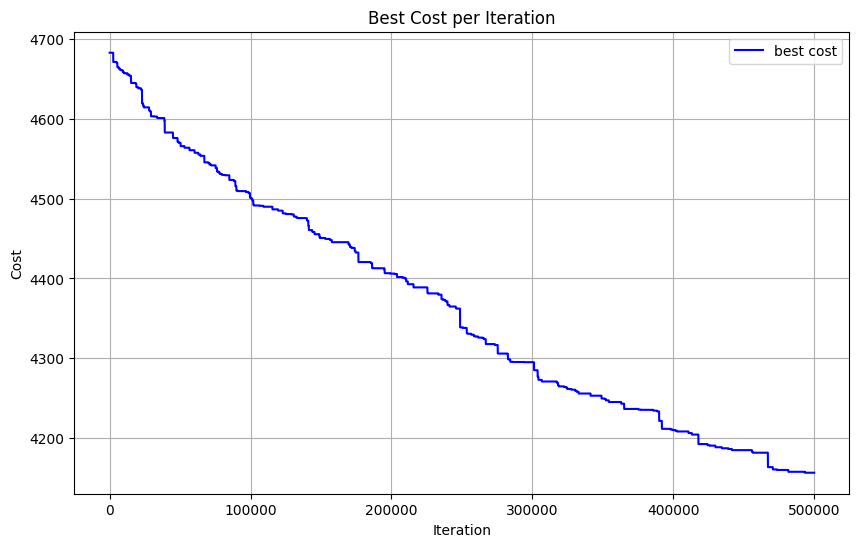

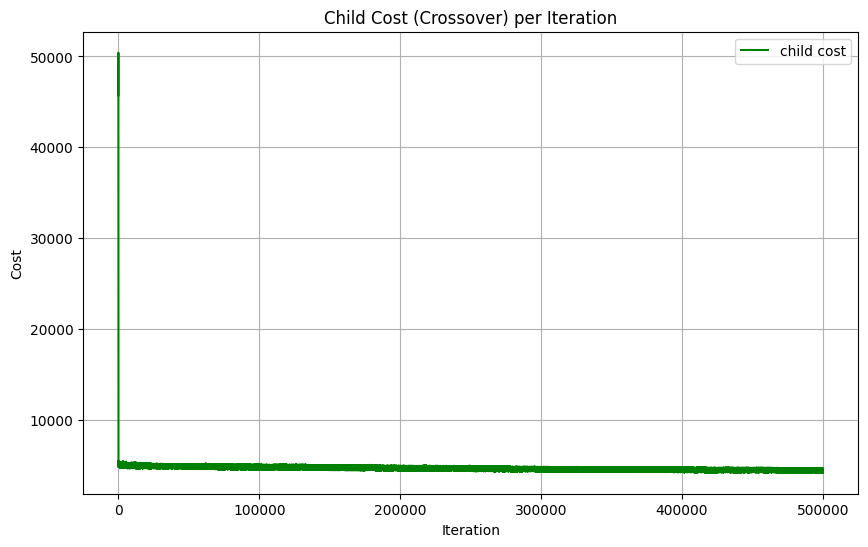

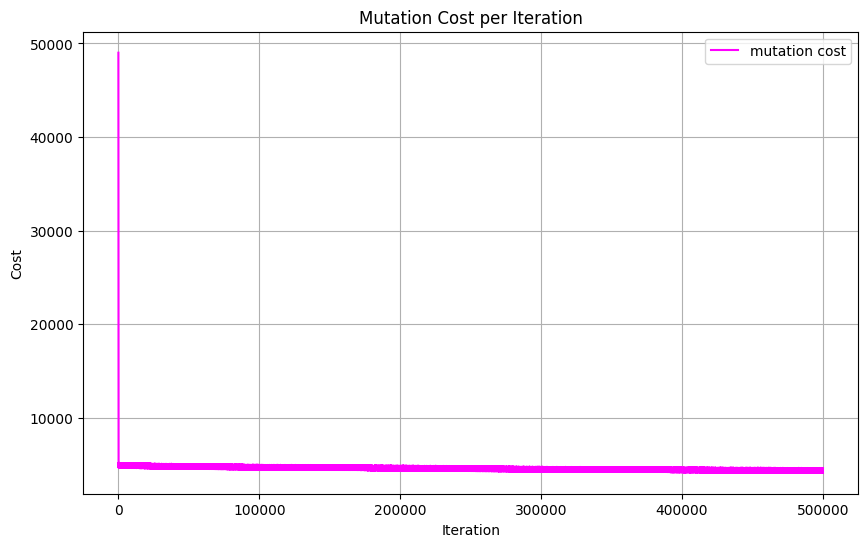

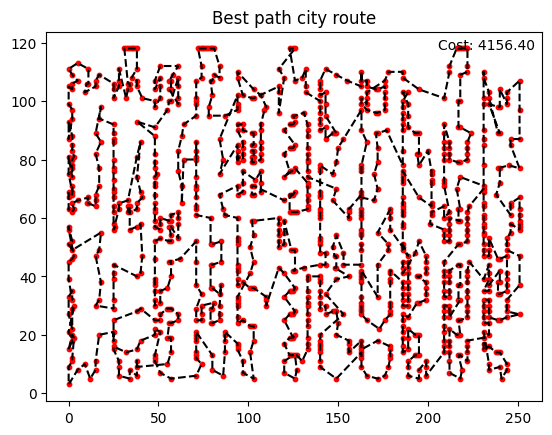

In [961]:
# Step 1
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()
# Run the GA
best_path, best_cost, best_costs, child_costs, mut_costs = ga_flip(coord_list)
# best_path, best_cost, best_costs, child_costs= ga_no_mut(coord_list)

end_time=time.time()

print('Execution Time: ' + str(end_time - start_time))
print('Path: ' + str(best_path.tolist()))
print('Cost: ' + str(best_cost))

# Run the GA



plot(best_costs, 'best cost', 'blue', 'Best Cost per Iteration')
plot(child_costs, 'child cost', 'green', 'Child Cost (Crossover) per Iteration')
plot(mut_costs, 'mutation cost', 'magenta', 'Mutation Cost per Iteration')

plot_best_path(coord_list, best_path, best_cost)